<a href="https://colab.research.google.com/github/SethupathyM/Unsupervised_ML_Clustering_and_Sentiment_Analysis_Zomato_Restaurant/blob/main/Zomato_Restaurant_Clustering_and_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Zomato is an Indian restaurant aggregator and food delivery start-up founded by Deepinder Goyal and Pankaj Chaddah in 2008. Zomato provides information, menus and user-reviews of restaurants, and also has food delivery options from partner restaurants in select cities.

India is quite famous for its diverse multi cuisine available in a large number of restaurants and hotel resorts, which is reminiscent of unity in diversity. Restaurant business in India is always evolving. More Indians are warming up to the idea of eating restaurant food whether by dining outside or getting food delivered. The growing number of restaurants in every state of India has been a motivation to inspect the data to get some insights, interesting facts and figures about the Indian food industry in each city. So, this project focuses on analysing the Zomato restaurant data for each city in India.

The Project focuses on Customers and Company, you have  to analyze the sentiments of the reviews given by the customer in the data and made some useful conclusion in the form of Visualizations. Also, cluster the zomato restaurants into different segments. The data is vizualized as it becomes easy to analyse data at instant. The Analysis also solve some of the business cases that can directly help the customers finding the Best restaurant in their locality and for the company to grow up and work on the fields they are currently lagging in.

This could help in clustering the restaurants into segments. Also the data has valuable information around cuisine and costing which can be used in cost vs. benefit analysis

Data could be used for sentiment analysis. Also the metadata of reviewers can be used for identifying the critics in the industry. 

# **Attribute Information**

## **Zomato Restaurant names and Metadata**
Use this dataset for clustering part

1. Name : Name of Restaurants

2. Links : URL Links of Restaurants

3. Cost : Per person estimated Cost of dining

4. Collection : Tagging of Restaurants w.r.t. Zomato categories

5. Cuisines : Cuisines served by Restaurants

6. Timings : Restaurant Timings

## **Zomato Restaurant reviews**
Merge this dataset with Names and Matadata and then use for sentiment analysis part

1. Restaurant : Name of the Restaurant

2. Reviewer : Name of the Reviewer

3. Review : Review Text

4. Rating : Rating Provided by Reviewer

5. MetaData : Reviewer Metadata - No. of Reviews and followers

6. Time: Date and Time of Review

7. Pictures : No. of pictures posted with review

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [3]:
# Reading the CSV file
df = pd.read_csv('/content/Mydrive/MyDrive/Capstone_Project_Unsupervised_ML_Zomato_Restaurant_Clustering_and_Sentiment_Analysis/Zomato Restaurant names and Metadata.csv')

In [4]:
# Shape
df.shape

(105, 6)

In [5]:
# Head
df.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [6]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In [7]:
# Null values
# Percentage of null values for each features
# print(list(df.columns))

for col in list(df.columns):
  if ((df[col].isnull().sum())/(len(df[col]))*100) > 50:
    # print((df[col].isnull().sum())/(len(df[col]))*100)
    print(col)

# As in the feature 'Collections' more than 50% of the observations are NULL values, so feature 'Collections' is droppped

Collections


In [8]:
# Dropping the 'Collections' feature
df.drop(columns = 'Collections',axis =1,inplace = True)

# Removing the observations with null values in 'Timings' feature
df.dropna(axis = 0,inplace = True)

# Print
print(df.shape)
print(df.info())

(104, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 104
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      104 non-null    object
 1   Links     104 non-null    object
 2   Cost      104 non-null    object
 3   Cuisines  104 non-null    object
 4   Timings   104 non-null    object
dtypes: object(5)
memory usage: 4.9+ KB
None


In [9]:
# Summary
df.describe()

,Name,Links,Cost,Cuisines,Timings
count,104,104,104,104,104
unique,104,104,29,91,77
top,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,500,"North Indian, Chinese",11 AM to 11 PM
freq,1,1,13,4,6


In [10]:
# Tokenizer
tokenizer = Tokenizer(num_words="MAX_NB_WORDS")
tokenizer.fit_on_texts(df[['Cuisines','Links','Timings']])

In [11]:
# Functions
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words

col_lsts = ['Links','Cuisines','Timings']
for col_lst in col_lsts:
  df[col_lst] = normalize(df[col_lst])

In [12]:
df.head()

,Name,Links,Cost,Cuisines,Timings
0,Beyond Flavours,httpswwwzomatocomhyderabadbeyondflavoursgachib...,800,chinese continental kebab european south india...,12noon to 330pm 630pm to 1130pm monsun
1,Paradise,httpswwwzomatocomhyderabadparadisegachibowli,800,biryani north indian chinese,11 am to 11 pm
2,Flechazo,httpswwwzomatocomhyderabadflechazogachibowli,"1,300",asian mediterranean north indian desserts,1130 am to 430 pm 630 pm to 11 pm
3,Shah Ghouse Hotel & Restaurant,httpswwwzomatocomhyderabadshahghousehotelresta...,800,biryani north indian chinese seafood beverages,12 noon to 2 am
4,Over The Moon Brew Company,httpswwwzomatocomhyderabadoverthemoonbrewcompa...,"1,200",asian continental north indian chinese mediter...,12noon to 11pm mon tue wed thu sun 12noon to 1...


In [13]:
pd.DataFrame(df.Cuisines.unique())

,0
0,chinese continental kebab european south india...
1,biryani north indian chinese
2,asian mediterranean north indian desserts
3,biryani north indian chinese seafood beverages
4,asian continental north indian chinese mediter...
...,...
86,asian sushi
87,chinese seafood
88,fast food salad
89,bakery mithai


In [14]:
# Tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words= 'english')

X = vectorizer.fit_transform(df['Cuisines'])

In [15]:
X.shape
# we have 47 unique words

(104, 47)

In [16]:
# Type of X object
type(X)

scipy.sparse.csr.csr_matrix

In [17]:
# Converting 'X' object to array
X = X.toarray()

In [18]:
type(X)

numpy.ndarray

In [19]:
# Elbow method to find appropriate 'K' value

In [20]:
# 'k-means++' would initialize the centroids far from each other because intialize the centroids nearby could lead to improper clustering

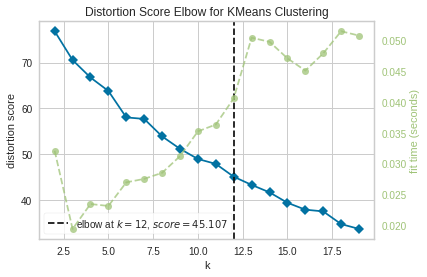

In [21]:
# KElbowvisualizer with metric as 'distortion

model = KMeans(init="k-means++",max_iter=300,random_state=0)
visualizer = KElbowVisualizer(model, k=(2,20),metric= 'distortion', timings= True, locate_elbow= True)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()

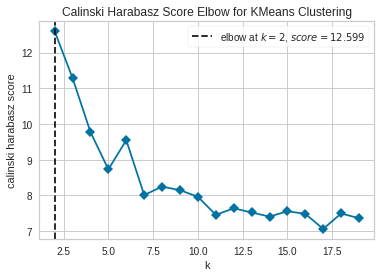

In [22]:
# KElbowvisualizer with metric as 'calinski_harabasz'

model = KMeans(init="k-means++",max_iter=300,random_state=0)
visualizer = KElbowVisualizer(model, k=(2,20),metric= 'calinski_harabasz', timings= False, locate_elbow= True)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()

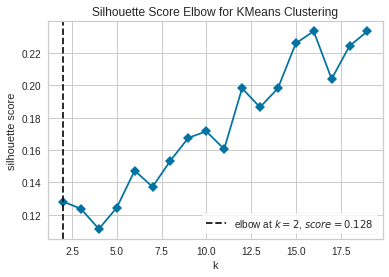

In [23]:
# # KElbowvisualizer with metric as 'silhouette'
model = KMeans(init="k-means++",max_iter=300,random_state=0)
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False, locate_elbow=True)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()

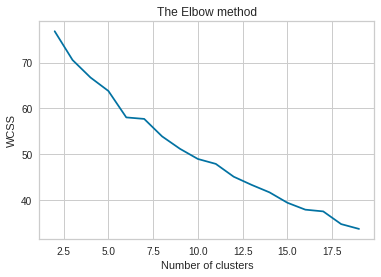

In [24]:
# Eblow method
wcss = []
for i in range(2,20):
  kmeans = KMeans(n_clusters =i,init='k-means++',random_state=0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(2,20),wcss)
plt.title('The Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
# looks like we can go with k clusters.

kmeans= KMeans(n_clusters=17, init= 'k-means++',max_iter=300, n_init=1,random_state = 0)

kmeans.fit(X)

KMeans(n_clusters=17, n_init=1, random_state=0)

In [26]:
#predict the labels of clusters.
labels = kmeans.fit_predict(X)

In [27]:
# Clusters center
clusters_center = kmeans.cluster_centers_

In [28]:
# clusters_center

In [29]:
# test a new text

X_new= vectorizer.transform([df['Cuisines'][26]])

y_pred_new= kmeans.predict(X_new)[0]

y_pred_new

12

In [30]:
# Silhouette score is for model validation for K-means,Hierarichical clustering.
# Silhouette Coefficient ranges between -1 to +1.
# Higher the Silhouette Coefficient better the clustering.

In [31]:
# Model Validation
# silhouette score of my clusters
print("Silhouette Coefficient: %0.3f"%silhouette_score(X, kmeans.labels_))

Silhouette Coefficient: 0.201


In [32]:
# Evaluation
# range_n_clusters = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
range_n_clusters = [ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,5))

For n_clusters = 6 The average silhouette_score is : 0.12714
For n_clusters = 7 The average silhouette_score is : 0.13912
For n_clusters = 8 The average silhouette_score is : 0.16436
For n_clusters = 9 The average silhouette_score is : 0.16981
For n_clusters = 10 The average silhouette_score is : 0.16452
For n_clusters = 11 The average silhouette_score is : 0.19031
For n_clusters = 12 The average silhouette_score is : 0.19927
For n_clusters = 13 The average silhouette_score is : 0.19124
For n_clusters = 14 The average silhouette_score is : 0.20067
For n_clusters = 15 The average silhouette_score is : 0.22355
For n_clusters = 16 The average silhouette_score is : 0.2351
For n_clusters = 17 The average silhouette_score is : 0.24635
For n_clusters = 18 The average silhouette_score is : 0.25122
For n_clusters = 19 The average silhouette_score is : 0.22653
For n_clusters = 20 The average silhouette_score is : 0.23899
For n_clusters = 21 The average silhouette_score is : 0.25589
For n_cluster

In [33]:
df['Cluster_labels'] = kmeans.labels_

In [34]:
df.head()

,Name,Links,Cost,Cuisines,Timings,Cluster_labels
0,Beyond Flavours,httpswwwzomatocomhyderabadbeyondflavoursgachib...,800,chinese continental kebab european south india...,12noon to 330pm 630pm to 1130pm monsun,8
1,Paradise,httpswwwzomatocomhyderabadparadisegachibowli,800,biryani north indian chinese,11 am to 11 pm,11
2,Flechazo,httpswwwzomatocomhyderabadflechazogachibowli,"1,300",asian mediterranean north indian desserts,1130 am to 430 pm 630 pm to 11 pm,13
3,Shah Ghouse Hotel & Restaurant,httpswwwzomatocomhyderabadshahghousehotelresta...,800,biryani north indian chinese seafood beverages,12 noon to 2 am,11
4,Over The Moon Brew Company,httpswwwzomatocomhyderabadoverthemoonbrewcompa...,"1,200",asian continental north indian chinese mediter...,12noon to 11pm mon tue wed thu sun 12noon to 1...,5


In [35]:
pd.DataFrame(df.groupby(['Cluster_labels'])['Cuisines'].count())

,Cuisines
Cluster_labels,
0,5
1,13
2,8
3,5
4,1
5,13
6,3
7,6
8,7


In [36]:
# Getting terms
terms = vectorizer.get_feature_names()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
len(terms)

47

In [38]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: andhra
 biryani
 indian
 chinese
 north
 hyderabadi
 south
 asian
 fast
 ice
Cluster 1: north
 indian
 chinese
 lebanese
 seafood
 hyderabadi
 arabian
 japanese
 sushi
 italian
Cluster 2: bakery
 desserts
 ice
 cream
 fast
 food
 mithai
 beverages
 indian
 mediterranean
Cluster 3: american
 burger
 wraps
 kebab
 salad
 desserts
 fast
 food
 north
 indian
Cluster 4: spanish
 european
 italian
 continental
 wraps
 goan
 food
 finger
 fast
 eastern
Cluster 5: asian
 continental
 italian
 indian
 north
 chinese
 modern
 sushi
 kebab
 goan
Cluster 6: momos
 eastern
 asian
 chinese
 north
 indian
 fast
 kebab
 american
 thai
Cluster 7: mughlai
 biryani
 north
 indian
 chinese
 hyderabadi
 beverages
 juices
 bakery
 desserts
Cluster 8: south
 indian
 north
 chinese
 kebab
 continental
 healthy
 european
 american
 italian
Cluster 9: food
 finger
 street
 arabian
 north
 indian
 kebab
 italian
 fast
 chinese
